<a href="https://colab.research.google.com/github/ansrl516/RTN_Paper/blob/main/RTN_f3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as Variable
import numpy as np

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
class Fig3(nn.Module):

    def __init__(self, M, n, EbNo):
        super().__init__()
        self.M = M
        self.n = n
        self.b = 1/(2*(math.log2(M)/n)*EbNo)
        self.Dense1 = nn.Linear(M,M)
        self.relu1 = nn.ReLU()
        self.Dense2 = nn.Linear(M,n)
        self.BatchNorm = nn.BatchNorm1d(num_features=n, affine=False, track_running_stats=True) # Paper says so...
        self.Dense3 = nn.Linear(n,M)
        self.relu3 = nn.ReLU()
        self.Dense4 = nn.Linear(M,M)
        self.softmax = nn.Softmax()

    def f(self,x):
        x = self.Dense1(x)
        x = self.relu1(x)
        x = self.Dense2(x)
        x = self.BatchNorm(x)
        return x

    def channel(self,x):
        noise = torch.normal(0,math.sqrt(self.b),size=(x.shape)) ## very important
        #print(x.shape)
        #print(x[0,:])
        #print(torch.norm(x))
        #print(torch.norm(x[1:20,1])**2 / 20)
        noise = noise.to(device)
        x = x + noise
        return x

    def g(self,x):
        x = self.Dense3(x)
        x = self.relu3(x)
        x = self.Dense4(x)
        x = self.softmax(x)
        return x

    def forward(self, x):
        x = self.f(x)
        x = self.channel(x)
        x = self.g(x)
        return x

In [ ]:
M = 2**7
n = 4
EbNo = 10**(-20/10)
b = (2*(math.log2(M)/n)*EbNo) ** -1
print(b)
print(torch.normal(0,math.sqrt(b),size=(n,)))

In [4]:
# Import Dataset of Epoch = 80, Batch_size = 32, Dataset = 6 * 10^4(Train) / 10^7(Test), Learning Rate = 0.001, Adam Optimizer
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

n, k = 7, 4
dataset_num = 10 ** 7
data = F.one_hot(torch.randint(high=2**k,size=(dataset_num,)),num_classes=2**k)
data = data.to(torch.torch.float32)

class CustomDataset(Dataset):
    def __init__(self, data):
        self.x_data = data
        self.y_data = data
    def __len__(self):
        return len(self.x_data)
    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

dataset = CustomDataset(data)
dataset_size = len(dataset)
train_size = int(0.006 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [5]:
# Training for EbNo = [-4:8:0.5]
EbNo_list = [10 ** (db/10) for db in np.arange(-4.0,8,0.5)]
#print(EbNo_list)
#EbNo_list = [10 ** (db/10) for db in np.arange(8,12,0.5)]
Ps_list = []
model = []
for EbNo in EbNo_list:
    history = []
    model.append(Fig3(2**k,n,EbNo))
    model[-1].to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model[-1].parameters(), lr=0.001)
    for epoch in range(80):
        print(epoch)
        cost = 0.0
        i = 0
        for (a, (x,y)) in enumerate(train_dataloader):
            i += 1
            x = x.to(device)
            y = y.to(device)

            output = model[-1](x)
            loss = criterion(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            cost += loss
        #print(EbNo, cost/i)
    with torch.no_grad():
        x, y = dataset[:]
        x = x.to(device)
        y = y.to(device)
        output = model[-1](x)
        output_index = np.argmax(output.detach().cpu().numpy(), axis=1)
        true_index = np.argmax(y.detach().cpu().numpy(), axis=1)
        Ps = len(np.nonzero(output_index - true_index)[0])/y.shape[0]
        Ps_list.append(Ps)
        print(Ps)

#file_name = './Ps_list.txt'
#with open(file_name, 'w+') as file:
#    file.write('\n'.join(Ps_list))

0


<ipython-input-3-06c7bb814970>:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


KeyboardInterrupt: ignored

In [ ]:
    y = test_dataset[1:600][1]
    v = torch.tensor([[0,1,0,0,0,0,0] for a in range(3)])
    print(y)
    output = model[8](y)
    print(output)
    output_index = np.argmax(output.detach().numpy(), axis=1)
    print(output_index)
    true_index = np.argmax(y.detach().numpy(), axis=1)
    print(true_index)
    Ps = len(np.nonzero(output_index - true_index)[0])/y.shape[0]
    print(Ps)
    print(model[8].channel(v)-v)

In [218]:
subtable = [] # subtable for (7,4) Hamming code bit
table = [] # table for (7,4) Hamming code bits' BPSK symbol
for a in range(2**4):
    x = [int(i) for i in '{0:04b}'.format(a)]
    p1, p2, p3 = (x[0]+x[1]+x[3])%2, (x[0]+x[2]+x[3])%2, (x[1]+x[2]+x[3])%2
    subtable.append(np.array([p1,p2,x[0],p3,x[1],x[2],x[3]]))
    table.append(np.array([p1-0.5,p2-0.5,x[0]-0.5,p3-0.5,x[1]-0.5,x[2]-0.5,x[3]-0.5])*math.sqrt(2))

def indexing(Map,y): # Map has numpy list as element, y is numpy list
    z = [y - Map[i] for i in range(16)]# broadcasting
    z = np.sum(np.square(z),-1)
    z = np.transpose(z,(1,0))
    z = np.argmin(z, -1)
    return z

In [110]:
a=np.array([[1,1,1],[2,2,2],[3,3,3],[4,4,4]])
b=[[1,1,1],[2,2,2]]
#print(a-torch.tensor(b)[0])
c= [a-np.array(b)[i] for i in range(len(b))]
print(c)
c = np.sum(c,-1)
print(c)
z= np.transpose(c,(1,0))
print(z)
print(np.argmin(z,-1))
print(a[:,1])

[array([[0, 0, 0],
       [1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]]), array([[-1, -1, -1],
       [ 0,  0,  0],
       [ 1,  1,  1],
       [ 2,  2,  2]])]
[[ 0  3  6  9]
 [-3  0  3  6]]
[[ 0 -3]
 [ 3  0]
 [ 6  3]
 [ 9  6]]
[1 1 1 1]
[1 2 3 4]


In [219]:
def dec2bin(x, bits):
    # mask = 2 ** torch.arange(bits).to(x.device, x.dtype)
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).float()
def bin2dec(b, bits):
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(b.device, b.dtype)
    return torch.sum(mask * b, -1)
print(bin2dec(torch.tensor([[0,1,1,0],[0,1,1,0]]),4))

tensor([6, 6])


In [220]:
## Uncoded BPSK (n,n)
def Transceiver3(x, n, EbNo): # x = input numpy list, else parameter
    x = 2*x-1
    b = 1/(2*(n/n)*EbNo)
    noise = np.random.normal(0,math.sqrt(b),size=(x.shape))
    x = x + noise
    x = (np.sign(x)+1)/2
    return bin2dec(x,n)

In [221]:
## Hamming BPSK (7,4) Hard Decision
def Transceiver3a_1(x, EbNo): # x as 4 bit list, hamming code as p1,p2,x[0],p3,x[1],x[2],x[3]
    p1, p2, p3 = (x[:,0]+x[:,1]+x[:,3])%2, (x[:,0]+x[:,2]+x[:,3])%2, (x[:,1]+x[:,2]+x[:,3])%2
    #print(p1)
    c = np.vstack((p1-0.5,p2-0.5,x[:,0]-0.5,p3-0.5,x[:,1]-0.5,x[:,2]-0.5,x[:,3]-0.5)) * 2
    #print(c)
    #print(c.shape)
    c = np.transpose(c,(1,0))
    #print(c)
    b = (2*(4/7)*EbNo) ** -1
    noise = np.random.normal(0,math.sqrt(b),size=(x.shape[0],7))
    r = c + noise
    y = np.sign(r)
    #print(y)
    return indexing(table,y)

In [222]:
## Hamming BPSK (7,4) Soft Decision
def Transceiver3a_2(x, EbNo):
    p1, p2, p3 = (x[:,0]+x[:,1]+x[:,3])%2, (x[:,0]+x[:,2]+x[:,3])%2, (x[:,1]+x[:,2]+x[:,3])%2
    c = np.vstack((p1-0.5,p2-0.5,x[:,0]-0.5,p3-0.5,x[:,1]-0.5,x[:,2]-0.5,x[:,3]-0.5)) * 2
    c = np.transpose(c,(1,0))
    b = (2*(4/7)*EbNo) ** -1
    noise = np.random.normal(0,math.sqrt(b),size=(x.shape[0],7))
    r = c + noise
    return indexing(table,r)

In [223]:
import random
test_dataset_int = []
test_dataset_bit = []
for x in range(10**6):
    intx = random.randint(0,15)
    test_dataset_int.append(intx)
test_dataset_int_np = np.array(test_dataset_int)
test_dataset_bit_np = np.array(test_dataset_bit)
test_dataset_int = torch.tensor(test_dataset_int)
test_dataset_bit = dec2bin(test_dataset_int,4)
print(test_dataset_bit[0],test_dataset_int[0])

tensor([1., 0., 1., 1.]) tensor(11)


In [224]:
EbNo_list = [10 ** (db/10) for db in np.arange(-4,8,0.5)]
print(EbNo_list)
P_uncoded4_list = []
for EbNo in EbNo_list:
    x, y = test_dataset_bit, test_dataset_int
    x = x.to(device)
    output_index = Transceiver3(x,4,EbNo).detach().numpy()
    true_index = y.numpy()
    h = np.nonzero(output_index - true_index)[0]
    Ps = len(h)/x.shape[0]
    P_uncoded4_list.append(Ps)
print(P_uncoded4_list)

[0.3981071705534972, 0.44668359215096315, 0.5011872336272722, 0.5623413251903491, 0.6309573444801932, 0.7079457843841379, 0.7943282347242815, 0.8912509381337456, 1.0, 1.1220184543019633, 1.2589254117941673, 1.4125375446227544, 1.5848931924611136, 1.7782794100389228, 1.9952623149688795, 2.2387211385683394, 2.51188643150958, 2.8183829312644537, 3.1622776601683795, 3.548133892335755, 3.9810717055349722, 4.466835921509632, 5.011872336272722, 5.623413251903491]
[0.560833, 0.531246, 0.498593, 0.464243, 0.428938, 0.392463, 0.354604, 0.317806, 0.279894, 0.242532, 0.206817, 0.173222, 0.141929, 0.11378, 0.087976, 0.067044, 0.049255, 0.0345, 0.023632, 0.015551, 0.009592, 0.005562, 0.003072, 0.001613]


In [ ]:
print(x[1:10])
print(Transceiver3a_1(x[1:10],10))
print(y[1:10])
print(y-)

In [225]:
EbNo_list = [10 ** (db/10) for db in np.arange(-4,8,0.5)]
P_HardHamming_list = []
for EbNo in EbNo_list:
    x, y = test_dataset_bit, test_dataset_int
    output_index = Transceiver3a_1(x,EbNo)
    true_index = y.numpy()
    h = np.nonzero(output_index - true_index)[0]
    Ps = len(h)/x.shape[0]
    print(Ps)
    P_HardHamming_list.append(Ps)

0.555528
0.523638
0.490202
0.454193
0.417151
0.379843
0.340719
0.300796
0.26286
0.225249
0.188776
0.154596
0.123373
0.096315
0.071959
0.052469
0.036523
0.024493
0.015799
0.009468
0.005399
0.002723
0.001405
0.000724


In [226]:
EbNo_list = [10 ** (db/10) for db in np.arange(-4,8,0.5)]
P_SoftHamming_list = []
for EbNo in EbNo_list:
    x, y = test_dataset_bit, test_dataset_int
    output_index = Transceiver3a_2(x,EbNo)
    true_index = y.numpy()
    h = np.nonzero(output_index - true_index)[0]
    Ps = len(h)/x.shape[0]
    print(Ps)
    P_SoftHamming_list.append(Ps)

0.486722
0.45088
0.413846
0.375152
0.333643
0.294194
0.255374
0.215302
0.180175
0.145515
0.114226
0.086834
0.063722
0.04519
0.030252
0.019594
0.011713
0.006738
0.003465
0.001762
0.000767
0.000352
0.000133
3.4e-05


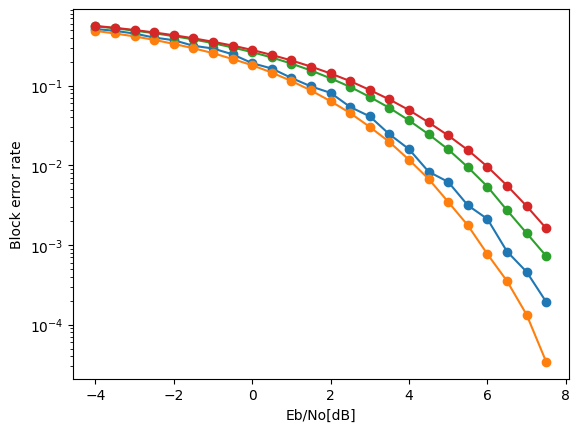

In [227]:
# Plot Fig3-a
import matplotlib.pyplot as plt
plt.yscale("log")
plt.plot(np.arange(-4,8,0.5),Ps_list,'o-',label="Autoencoder (7,4)")
plt.plot(np.arange(-4,8,0.5),P_SoftHamming_list,'-o',label="Hamming (7,4) MLD")
plt.plot(np.arange(-4,8,0.5),P_HardHamming_list,'-o',label="Hamming (7,4) Hard Decision")
plt.plot(np.arange(-4,8,0.5),P_uncoded4_list,'-o',label="Uncoded BPSK (4,4)")
plt.xlabel('Eb/No[dB]')
plt.ylabel('Block error rate')
plt.legend(['Autoencoder(7,4)','Hamming(7,4) MLD','Hamming (7,4) Hard Decision','Uncoded BPSK (4,4)'])
plt.show()

In [232]:
# Draw Plot
n = 4
A = [torch.tensor([int(i) for i in '{0:04b}'.format(a)]) for a in range(2**n)]
coord = [model[0].f(a) for a in A]

RuntimeError: ignored